In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novartis-data/Train.csv
/kaggle/input/novartis-data/sample_submission.csv
/kaggle/input/novartis-data/Test.csv


In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("/kaggle/input/novartis-data/Train.csv")
submit = pd.read_csv("/kaggle/input/novartis-data/sample_submission.csv")
test = pd.read_csv("/kaggle/input/novartis-data/Test.csv")

In [4]:
train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


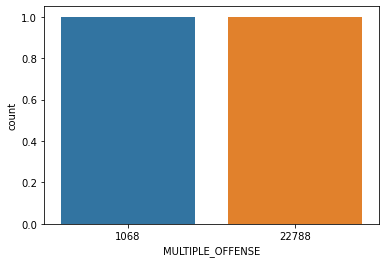

In [9]:
sns.countplot(train.MULTIPLE_OFFENSE.value_counts())

In [10]:
train.MULTIPLE_OFFENSE.value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [12]:
test.shape

(15903, 17)

In [14]:

train.head(2)

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1


In [15]:
X = train.drop(['MULTIPLE_OFFENSE', 'DATE', 'INCIDENT_ID'],axis=1)
eval_X = test.drop(['DATE','INCIDENT_ID'],axis=1)
Y = train['MULTIPLE_OFFENSE']

incident_ids_train = train['INCIDENT_ID']
incdent_ids_test = test['INCIDENT_ID']


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)

In [21]:
X_train.shape, y_train.shape

((10708, 15), (10708,))

In [23]:
X_test.shape

(7873, 15)

In [36]:
X_train.fillna(0, inplace=True)
X_cv.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
eval_X.fillna(0, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

In [39]:
X_cv = pd.DataFrame(scaler.transform(X_cv), columns = X_cv.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
eval_X = pd.DataFrame(scaler.transform(eval_X), columns = eval_X.columns)

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
k = [1,3,5,7,9,11,13,15]

for i in k:
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    
    y_train_pred = neigh.predict_proba(X_train)[:,1]
    y_cv_pred = neigh.predict_proba(X_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

Text(0, 0.5, 'AUC')

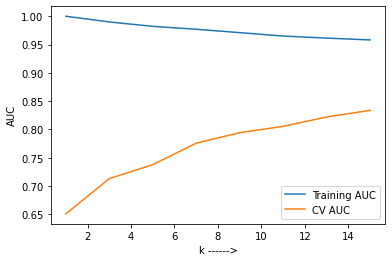

In [57]:
plt.plot(k, train_auc, label = 'Training AUC')
plt.plot(k, cv_auc, label = 'CV AUC')
plt.legend()
plt.xlabel('k ------>')
plt.ylabel("AUC")


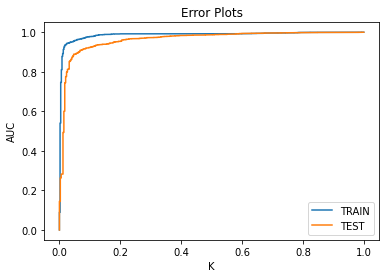

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

best_k_value = 13

neigh = svm.SVC(probability=True, class_weight={0: 10})


neigh.fit(X_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label = 'TRAIN')
plt.plot(test_fpr, test_tpr, label = 'TEST')
plt.legend()
plt.xlabel('K')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()

In [64]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score

y_train_predict = neigh.predict(X_train)
y_test_predict = neigh.predict(X_test)

train_confusion_matrix = confusion_matrix(y_train, y_train_predict)
test_confusion_matrix = confusion_matrix(y_test, y_test_predict)

In [65]:
print("train CM:")
print(train_confusion_matrix)

print("test CM:")
print(test_confusion_matrix)


train CM:
[[ 446   27]
 [ 412 9823]]
test CM:
[[ 280   62]
 [ 372 7159]]


In [66]:
print("Training F1 score")
print(f1_score(y_train, y_train_predict))
print("Test F1 score")
print(f1_score(y_test, y_test_predict))


Training F1 score
0.9781428927059994
Test F1 score
0.9705802603036876


In [68]:
# eval_X.head()

In [85]:
res = neigh.predict(eval_X)
res_df = pd.DataFrame({'MULTIPLE_OFFENSE':res, 'INCIDENT_ID': incdent_ids_test})
res_df1 = res_df[['INCIDENT_ID','MULTIPLE_OFFENSE']]


In [86]:
print(res_df.shape)

(15903, 2)


In [89]:
res_df1.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [91]:
res_df1.to_csv("results1.csv",index = False)